In [1]:

from BondFlow.data.dataloader import get_dataloader
from BondFlow.models.Loss import *
import torch
import os
import random
import numpy as np
from collections import defaultdict
import BondFlow.data.SM_utlis as smu


/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:70: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


In [2]:
from BondFlow.data import utils as iu
import logging
import torch.nn as nn


import torch

import logging
from hydra.core.hydra_config import HydraConfig
import numpy as np
import random
import hydra
from hydra import initialize, compose
from BondFlow.models.mymodel import *

from omegaconf import OmegaConf

def make_deterministic(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


#conf.inference.ckpt_override_path= "../Train/weights_base3/best_model.pth"
config_file = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/base.yaml"
config_path = os.path.dirname(config_file)
config_path = os.path.relpath(config_path)
config_name = os.path.basename(config_file).split(".yaml")[0]

# 创建模型 + DDP包装 
with initialize(version_base=None, config_path=config_path):
    conf = compose(config_name=config_name)
# with initialize(version_base=None, config_path="../config/inference"):
#     conf = compose(config_name="base")
# 调用主函数
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

log = logging.getLogger(__name__)
if conf.inference.deterministic:
    make_deterministic()

# Check for available GPU and print result of check
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    log.info(f"Found GPU with device_name {device_name}. Will run RFdiffusion on {device_name}")
else:
    log.info("////////////////////////////////////////////////")
    log.info("///// NO GPU DETECTED! Falling back to CPU /////")
    log.info("////////////////////////////////////////////////")

# Initialize sampler and target/contig.
sampler = MySampler(conf,device=device)  # 使用传入的 device 参数

loading APMBackboneWrapper
loading APMBackboneWrapper
[APMBackboneWrapper] Loaded wrapper from /home/fit/lulei/WORK/xjt/Protein_design/BondFlow/Train/weight_apm_backbone_monomer43/best_model.pth: loaded~763/1340, missing=12, unexpected=577, strict=False
loading APMSidechainWrapper
loading APMSidechainWrapper
[APMSidechainWrapper] Loaded wrapper from /home/fit/lulei/WORK/xjt/Protein_design/BondFlow/Train/weight_apm_sidechain_monomer17/best_model.pth: loaded~546/1123, missing=10, unexpected=577, strict=False


In [3]:
batch_size =8
pdb_list_path = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/LINK_tmp/cluster.tsv"
pdb_dir = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/LINK_CIF"

cache_dir = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/data_cache/"
dataloader_train,dataloader_val = get_dataloader(conf, batch_size, pdb_list_path, pdb_dir,distributed=False, num_workers=0, 
                   crop_length=270, device='cpu',rank=None, num_replicas=None,seed=44,
                   val_split=0.025,sampling_ratios={'monomer': 1},
                   cache_dir = cache_dir)#, link_span_workers=46,link_span_alpha=0.5)
print(len(dataloader_train),len(dataloader_val))

Training set: 30577 clusters.
self.num_replicas None
self.rank None
self.total_size 30577
Validation set: 785 clusters.
self.num_replicas None
self.rank None
self.total_size 785
3822 98


In [4]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# params = count_parameters(sampler.model)
# print(f"模型的参数总量: {params}")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def plot_tensor_heatmap(tensor, title="Tensor Heatmap", cmap="viridis"):
    """
    绘制L×L tensor矩阵的热图
    
    参数:
    tensor -- 输入的L×L矩阵
    title -- 热图标题(可选)
    cmap -- 颜色映射(可选)
    """
    plt.figure(figsize=(8, 6))
    
    # 显示热图
    im = plt.imshow(tensor, cmap=cmap)
    
    # 添加颜色条
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # 设置标题和坐标轴
    plt.title(title)
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    
    # 显示网格线(可选)
    plt.grid(False)
    
    plt.show()



In [6]:

def log_nan_loss(loss_tensor, loss_name, pdb_id, log_file_path):
    """
    Logs a message if the loss is NaN.

    Args:
        loss_tensor (torch.Tensor): The loss value.
        loss_name (str): The name of the loss (e.g., 'frame', 'seq').
        batch_data (dict): The batch data dictionary, containing 'pdb_id'.
        log_file_path (str): The path to the log file.
    
    Returns:
        bool: True if the loss was NaN, False otherwise.
    """
    if torch.isnan(loss_tensor):
        with open(log_file_path, 'a') as f:
            pdb_ids = " ".join(pdb_id)
            log_message = f"{loss_name} nan {pdb_ids} {loss_tensor.item()}\\n"
            f.write(log_message)
            print(log_message)
        return True
    return False
log_file_path = "/home/fit/lulei/WORK/xjt/Protein_design/RFdiffusion/mytest/tests/train_log.txt"


def print_gpu_memory(loss_name):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        print(f'GPU Memory after {loss_name}: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

def model_forward(sampler,batch_data,criterion_frame, criterion_seq, 
                                                criterion_bond,
                                                criterion_FAPE,
                                                criterion_torsion,
                                                criterion_bond_coh,
                                                eps_t = 5e-3,
                                                criterion_clash=None):
    
    # 1. Extract data from batch and move to device
    xyz_orig = batch_data['full_xyz'].to(sampler.device) # (B, L, 14, 3)
    seq_target = batch_data['full_seq'].to(sampler.device)
    bond_matrix_target = batch_data['full_bond_matrix'].to(sampler.device)
    res_mask = batch_data['res_mask'].to(sampler.device)
    str_mask = batch_data['full_mask_str'].to(sampler.device)
    seq_mask = batch_data['full_mask_seq'].to(sampler.device)
    bond_mask = batch_data['full_bond_mask'].to(sampler.device)
    head_mask = batch_data['full_head_mask'].to(sampler.device)
    tail_mask = batch_data['full_tail_mask'].to(sampler.device)
    pdb_idx = batch_data['full_pdb_idx']
    rf_idx = batch_data['full_rf_idx'].to(sampler.device)
    alpha_target = batch_data['full_alpha'].to(sampler.device)
    alpha_alt_target = batch_data['full_alpha_alt'].to(sampler.device)  # [L,10,2] for alpha torsions, [L,10,2] for alpha torsion alt
    alpha_tor_mask = batch_data['full_alpha_tor_mask'].to(sampler.device)
    pdb_id = batch_data['pdb_id']
    N_C_anchor = batch_data['full_N_C_anchor'].to(sampler.device)
    final_res_mask = res_mask.float() * (1 - head_mask.float()) * (1 - tail_mask.float())
    
    print_gpu_memory('data to device')

    
    # Create dummy tensors for ss since it's not in batch_data
    B, L = seq_target.shape

    # 2. Get random timestep
    partial_T = torch.rand((1,), device=sampler.device).repeat(B) * (1 - eps_t)    
    print("partial_T",partial_T)
    # 3. Noise the data using interpolant's sample method
    xyz_noised, seq_noised, bond_noised,xyz_centered,rotmats =  sampler.sample_with_interpolant(xyz_orig[:,:,:3,:], 
                                                                            seq_target, 
                                                                            bond_matrix_target, 
                                                                            res_mask, 
                                                                            str_mask, 
                                                                            seq_mask,
                                                                            bond_mask, 
                                                                            pdb_idx, 
                                                                            partial_T,
                                                                            head_mask=head_mask,
                                                                            tail_mask=tail_mask,
                                                                            N_C_anchor=N_C_anchor)
    print("xyz_noised 0",xyz_noised[0,0,...])
    print("xyz_noised 1",xyz_noised[0,1,...])
    print_gpu_memory('after sample_with_interpolant')

    # 4. Preprocess batch for the model

    # 4. Preprocess batch for the model
    # plot_tensor_heatmap(bond_noised[0].cpu(), title="Noised Bond Matrix")
    # print(bond_noised[0][(bond_noised[0]>0)& (bond_noised[0]<1)])
    # plot_tensor_heatmap(bond_noised[1].cpu(), title="Noised Bond Matrix")
    # plot_tensor_heatmap(bond_matrix_target[0].cpu(), title="Bond Matrix")
    # plot_tensor_heatmap(bond_matrix_target[1].cpu(), title="Bond Matrix")
    # print(bond_noised[1][(bond_noised[1]>0)& (bond_noised[1]<1)])
    # plot_tensor_heatmap(bond_mask[0].cpu(), title="Bond mask")
    # plot_tensor_heatmap(bond_mask[1].cpu(), title="Bond mask")
    
    print_gpu_memory('after _preprocess_batch')
    # plot_tensor_heatmap(res_dist_matrix[0].cpu(), title="CA")
    # plot_tensor_heatmap(res_dist_matrix[1].cpu(), title="CA Dist Matrix")
    # 5. Model forward pass
    start_time = time.time()
        
    logits_aa, xyz_pred, alpha_s, bond_matrix = sampler.model(
            seq_noised=seq_noised,
            xyz_noised=xyz_noised,
            bond_noised=bond_noised,
            rf_idx=rf_idx,
            pdb_idx=pdb_idx,
            alpha_target=alpha_target,
            alpha_tor_mask=alpha_tor_mask,
            partial_T=partial_T,
            str_mask=str_mask,
            seq_mask=seq_mask,
            N_C_anchor=N_C_anchor,
            head_mask=head_mask,
            tail_mask=tail_mask,
            bond_mask=bond_mask,
            res_mask=res_mask,
            use_checkpoint=False,
            trans_1=xyz_centered[:,:,1,:].to(xyz_noised.dtype),
            rotmats_1= rotmats.to(xyz_noised.dtype),
            aatypes_1=seq_target.long(),
            bond_mat_1=bond_matrix_target,

        )
    seq_pred = torch.argmax(logits_aa, dim=-1)

    seq_noised_mask = (seq_noised == du.MASK_TOKEN_INDEX)
    seq_res_mask = seq_mask.float() * final_res_mask.float() * seq_noised_mask.float()
    seq_pred = seq_pred * seq_res_mask.float() + (1 - seq_res_mask.float()) * seq_target.long()

    str_res_mask = str_mask.float() * res_mask.float() 
    times = xyz_pred.size(1)
    # Reshape str_res_mask to broadcast with xyz_pred: (B, L) -> (B, 1, L, 1, 1)
    str_res_mask_expanded = str_res_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)
    xyz_pred = xyz_pred * str_res_mask_expanded + ( 1 - str_res_mask_expanded) * xyz_centered.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]


    print("model forward time:", time.time() - start_time)
    print_gpu_memory('after model forward pass')
    
    # return logits_2d, logits_aa, logits_exp, xyz_pred, alpha_s, bond_matrix, lddt
    # 计算frame损失
    target_times =xyz_centered.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]
    noise_times = xyz_noised.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]
    # print("center of xyz_pred:",xyz_pred[...,1,:].mean(dim=(1,2)))
    # print("center of xyz_noised:",noise_times[...,1,:].mean(dim=(1,2)))
    # print("center of xyz_target:",target_times[...,1,:].mean(dim=(1,2)))
    loss_frame_start = time.time()
    loss_frame = criterion_frame(xyz_pred, target_times,noise_times, mask = str_res_mask.bool(),t=partial_T)
    log_nan_loss(loss_frame, 'frame', pdb_id, log_file_path)
    loss_frame_time = time.time() - loss_frame_start
    print(f"frame loss time: {loss_frame_time}")
    print_gpu_memory('after loss_frame')


    loss_FAPE_start = time.time()
    loss_FAPE = criterion_FAPE(xyz_pred[:,-1,...],xyz_centered,final_res_mask, str_mask)
    #loss_FAPE = criterion_FAPE(xyz_pred,target_times,res_mask, str_mask)
    log_nan_loss(loss_FAPE, 'FAPE', pdb_id, log_file_path)
    loss_FAPE_time = time.time() - loss_FAPE_start
    print(f"FAPE loss time: {loss_FAPE_time}")
    print_gpu_memory('after loss_FAPE')

    loss_seq_start = time.time()    
    # 计算序列损失        
   
    loss_seq = criterion_seq(logits_aa, seq_target, mask=seq_res_mask.bool())
    log_nan_loss(loss_seq, 'seq', pdb_id, log_file_path)
    loss_seq_time = time.time() - loss_seq_start
    print(f"seq loss time: {loss_seq_time}")
    print_gpu_memory('after loss_seq')

    #计算键合矩阵的loss
    mask_res_bond_2d = (res_mask.unsqueeze(2).float() * res_mask.unsqueeze(1).float() * bond_mask.float()).bool()
    loss_bond_start = time.time()
    loss_bond = criterion_bond(bond_matrix, bond_matrix_target, mask_res_bond_2d)
    loss_bond_time = time.time() - loss_bond_start
    print(f"bond loss time: {loss_bond_time}")
    print_gpu_memory('after loss_bond')
    # plot_tensor_heatmap(bond_matrix_target[0].detach().cpu(), title="Bond Matrix")
    # plot_tensor_heatmap(bond_matrix[0].detach().cpu(), title="Bond Matrix pred")

    # # 用assert检查 bond_matrix[0] 是否为双随机矩阵（行和列和均接近1）
    # # 只在 mask_2d 有效位置检测双随机性
    # bm = bond_matrix[0].detach().cpu()
    # mask = mask_2d[0].detach().cpu()
    # # 为避免全0行/列影响，限定检测在 mask 有效的位置
    # row_valid = mask.sum(dim=1) > 0
    # col_valid = mask.sum(dim=0) > 0
    # row_sums = bm.sum(dim=1)
    # col_sums = bm.sum(dim=0)
    # assert torch.allclose(row_sums[row_valid], torch.ones_like(row_sums[row_valid]), atol=1e-2), \
    #     f"Row sums not close to 1: min={row_sums[row_valid].min().item()}, max={row_sums[row_valid].max().item()}"
    # assert torch.allclose(col_sums[col_valid], torch.ones_like(col_sums[col_valid]), atol=1e-2), \
    #     f"Column sums not close to 1: min={col_sums[col_valid].min().item()}, max={col_sums[col_valid].max().item()}"
    # plot_tensor_heatmap(bond_noised[0].detach().cpu(), title="bond_noised")

    t_threshold = 0.25
    partial_T_mask = (partial_T > t_threshold)

    # 计算clash loss
    sapmle_bond_start = time.time()
    mask_res_2d = (res_mask.unsqueeze(2).float() * res_mask.unsqueeze(1).float()).bool()
    bond_matrix_sampled = smu.sample_permutation(bond_matrix, mask_res_2d)
    sample_bond_time = time.time() - sapmle_bond_start
    print(f"sample bond time: {sample_bond_time}")

    allatom_start = time.time()
 
    RTframes,allatom_xyz_withCN = sampler.allatom(seq_pred,xyz_pred[:,-1,...],
                                alpha_s,use_H=False,bond_mat=bond_matrix_sampled,
                                link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
                                res_mask=res_mask)

    # RTframes,allatom_xyz_true = sampler.allatom(seq_target,xyz_centered,
    #                         alpha_target,use_H=False,bond_mat=bond_matrix_target,
    #                         link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
    #                         res_mask=res_mask)

    allatom_time = time.time() - allatom_start

    print_gpu_memory('after allatom')


    loss_clash_start = time.time()
    loss_clash = criterion_clash(N_C_anchor,allatom_xyz_withCN, seq_target, final_res_mask*partial_T_mask[:,None].float(),
                                )
    log_nan_loss(loss_clash, 'clash', pdb_id, log_file_path)
    loss_clash_time = time.time() - loss_clash_start
    print(f"clash loss time: {loss_clash_time}")
    print_gpu_memory('after loss_clash')
    # 计算torsion loss
    loss_torsion_start = time.time()
    alpha_tor_res_mask = alpha_tor_mask.float() * final_res_mask[:,:,None].float()*partial_T_mask[:,None,None].float()
    loss_torsion = criterion_torsion(alpha_s, alpha_target, alpha_alt_target, alpha_tor_res_mask,bond_mat=bond_matrix)
    log_nan_loss(loss_torsion, 'torsion', pdb_id, log_file_path)
    loss_torsion_time = time.time() - loss_torsion_start
    print(f"torsion loss time: {loss_torsion_time}")
    print_gpu_memory('after loss_torsion')
    loss_bond_coh_start = time.time()   
    loss_bond_coh = criterion_bond_coh(
        bond_matrix=bond_matrix,
        res_mask=res_mask*partial_T_mask[:,None].float(),
        #seq_logits=logits_aa,
        true_seq = seq_target,
        seq_labels = seq_target,
        mask_2d=None,
        all_atom_coords = allatom_xyz_withCN,
        aatype = seq_target,
        t = None,
        head_mask=head_mask,
        tail_mask=tail_mask,
        nc_anchor=N_C_anchor,
        # true_bond_matrix=bond_matrix_target.float(),
    )
    
    log_nan_loss(loss_bond_coh, 'bond_coh', pdb_id, log_file_path)
    loss_bond_coh_time = time.time() - loss_bond_coh_start
    print(f"bond_coh loss time: {loss_bond_coh_time}")
    print_gpu_memory('after loss_bond_coh')
    print("model loss-forward time:", time.time() - start_time)



    from rfdiff.util import writepdb
    import numpy as np

    # Get the first sample from the batch
    atoms_to_save = allatom_xyz_withCN[0].cpu()
    seq_to_save = seq_target[0].cpu()
    res_mask_to_save = res_mask[0].cpu().numpy()

    # Filter atoms and sequence based on residue mask
    L = atoms_to_save.shape[0]
    res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
    filtered_atoms = atoms_to_save[res_indices]
    filtered_seq = seq_to_save[res_indices]

    # Prepare arguments for writepdb
    outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output.pdb"
    res = filtered_seq
    ch = ['A'] * len(filtered_seq) # Assuming a single chain 'A'
    resi = res_indices + 1 # PDB residue indices are 1-based

    # Write the PDB file
    writepdb(outfile, filtered_atoms, res)

    print(f"Saved PDB file to {outfile}")

    # outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output_orig.pdb"
    # res = seq_target[0].cpu()
    # atoms_to_save = allatom_xyz_orig[0].cpu()
    # res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
    # filtered_atoms = atoms_to_save[res_indices]
    # filtered_seq = seq_to_save[res_indices]
    # res = filtered_seq
    # writepdb(outfile, filtered_atoms, res)

    # plot_tensor_heatmap(bond_matrix_target[0].detach().cpu(), title="Bond Matrix")
    # plot_tensor_heatmap(bond_matrix[0].detach().cpu(), title="Bond Matrix pred")
    # plot_tensor_heatmap(bond_matrix_sampled[0].detach().cpu(), title="bond_matrix_sampled")


        # 输出bond_mat中元素1的索引对
    bond_indices = torch.nonzero(bond_matrix_target* (1- torch.eye(bond_matrix_target.shape[1],dtype=torch.float32,device=bond_matrix_target.device).unsqueeze(0)) == 1)
    print("bond_matrix == 1 的索引对:")
    for idx in bond_indices:
        # idx is tensor([batch_idx, i, j])
        batch_idx, i, j = idx.tolist()
        print(f"batch {batch_idx}: ({i}, {j})")

    return loss_frame, loss_seq, loss_bond, loss_clash,loss_FAPE, loss_torsion, loss_bond_coh,partial_T,  seq_pred, res_mask


In [7]:
batch_data = None
dataloader_train.sampler.set_epoch(1)
for i, batch in enumerate(dataloader_train):
    batch_data = batch
    break


chosen_pdb_id AF-O67766-F1-model_v4_A
[['A/1-A/126:seq_PNA:str_PNA', 'New_144-144']]
chosen_pdb_id 3ZVS_A
[['A/1-A/41:seq_PNA:str_PNA', 'A/42-A/58:seq_FIX:str_FIX', 'A/59-A/102:seq_PNA:str_PNA', 'A/103-A/119:seq_FIX:str_FIX', 'A/120-A/158:seq_PNA:str_PNA', 'New_112-112']]
chosen_pdb_id 1LN0_B
[['B/1-B/31:seq_PNA:str_PNA', 'B/32-B/48:seq_FIX:str_FIX', 'B/49-B/94:seq_PNA:str_PNA', 'New_176-176']]
chosen_pdb_id AF-P47394-F1-model_v4_A
[['A/100-A/167:seq_PNA:str_PNA', 'A/168-A/194:seq_FIX:str_FIX', 'A/195-A/260:seq_PNA:str_PNA', 'A/261-A/290:seq_FIX:str_FIX', 'A/291-A/369:seq_PNA:str_PNA']]
chosen_pdb_id AF-Q501D5-F1-model_v4_A
[['A/30-A/299:seq_PNA:str_PNA']]
chosen_pdb_id AF-O67788-F1-model_v4_A
[['A/1-A/68:seq_PNA:str_PNA', 'A/69-A/87:seq_FIX:str_FIX', 'A/88-A/134:seq_PNA:str_PNA', 'A/135-A/148:seq_FIX:str_FIX', 'A/149-A/208:seq_PNA:str_PNA', 'New_62-62']]
chosen_pdb_id AF-Q2YJ82-F1-model_v4_A
[['A/36-A/159:seq_PNA:str_PNA', 'A/160-A/186:seq_FIX:str_FIX', 'A/187-A/305:seq_PNA:str_PNA']]

In [8]:
batch_data.keys()
print(batch_data['full_pdb_idx'])
print(batch_data['full_seq'].shape)

[[('A', 1), ('A', 2), ('A', 3), ('A', 4), ('A', 5), ('A', 6), ('A', 7), ('A', 8), ('A', 9), ('A', 10), ('A', 11), ('A', 12), ('A', 13), ('A', 14), ('A', 15), ('A', 16), ('A', 17), ('A', 18), ('A', 19), ('A', 20), ('A', 21), ('A', 22), ('A', 23), ('A', 24), ('A', 25), ('A', 26), ('A', 27), ('A', 28), ('A', 29), ('A', 30), ('A', 31), ('A', 32), ('A', 33), ('A', 34), ('A', 35), ('A', 36), ('A', 37), ('A', 38), ('A', 39), ('A', 40), ('A', 41), ('A', 42), ('A', 43), ('A', 44), ('A', 45), ('A', 46), ('A', 47), ('A', 48), ('A', 49), ('A', 50), ('A', 51), ('A', 52), ('A', 53), ('A', 54), ('A', 55), ('A', 56), ('A', 57), ('A', 58), ('A', 59), ('A', 60), ('A', 61), ('A', 62), ('A', 63), ('A', 64), ('A', 65), ('A', 66), ('A', 67), ('A', 68), ('A', 69), ('A', 70), ('A', 71), ('A', 72), ('A', 73), ('A', 74), ('A', 75), ('A', 76), ('A', 77), ('A', 78), ('A', 79), ('A', 80), ('A', 81), ('A', 82), ('A', 83), ('A', 84), ('A', 85), ('A', 86), ('A', 87), ('A', 88), ('A', 89), ('A', 90), ('A', 91), ('A', 

In [9]:
print(batch_data['full_seq'][0])
print(batch_data['full_head_mask'][0])
print(batch_data['full_tail_mask'][0])
print(batch_data['full_rf_idx'][0])
N_index = 21#torch.where(batch_data['full_N_C_anchor'][0,:,:,0]==1)[0].max()
C_index =20 #`torch.where(batch_data['full_N_C_anchor'][0,:,:,1]==1)[0].min()
N_vuratal_index = 0#torch.where(batch_data['full_N_C_anchor'][0,:,:,0]==1)[0].min()
C_vuratal_index = 135#torch.where(batch_data['full_N_C_anchor'][0,:,:,1]==1)[0].max()
print(N_index,C_index)
print(torch.where(batch_data['full_N_C_anchor'][0,:,:,1]==1))
print(torch.where(batch_data['full_N_C_anchor'][0,:,:,0]==1))
print(f"N residue {N_index}",batch_data['full_xyz'][0,N_index,:3,:])
print(f"C residue {C_index}",batch_data['full_xyz'][0,C_index,:3,:])
print(f"N virtual residue {N_vuratal_index}",batch_data['full_xyz'][0,N_vuratal_index,:3,:])
print(f"C virtual residue {C_vuratal_index}",batch_data['full_xyz'][0,C_vuratal_index,:3,:])
print((((batch_data['full_xyz'][0,C_vuratal_index,1,:]-batch_data['full_xyz'][0,N_vuratal_index,1,:])**2).sum())**0.5)

tensor([16, 12,  9, 15,  6, 12,  6,  6,  9,  6, 10, 18, 10, 15, 11, 10, 14, 19,
        14, 11, 15,  2,  1, 18,  9,  1, 14, 11,  7,  7, 11, 19, 13, 11, 14, 14,
         1, 19, 16,  2, 17,  6,  0,  1,  0,  9, 17,  6, 10,  1,  6,  5, 13, 11,
         7,  3,  0,  9,  3, 18,  6,  9, 15, 19,  3,  9, 16, 10,  9, 10, 14,  2,
         1,  1, 11,  1,  3,  9,  3,  2, 12, 10, 11, 15, 10, 17,  3, 19, 12,  6,
        11,  0,  7, 19,  9, 11,  2,  3,  2, 10,  9, 13,  6, 19,  8, 16, 19, 11,
        11,  9,  6, 11,  7, 11,  6,  7, 19,  9,  9, 11,  9,  1, 14, 13,  5, 15,
        14, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 

(tensor([0, 0, 0, 0, 0, 0]), tensor([  0,  13,  47,  86,  90, 127]), tensor([127,  47,  13,  90,  86,   0]))


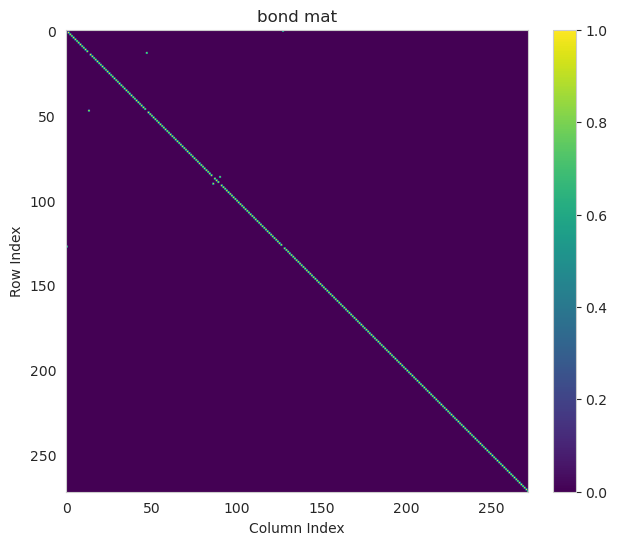

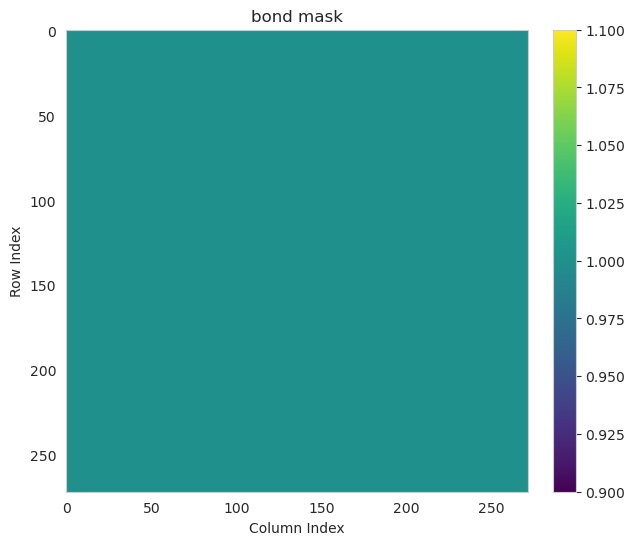

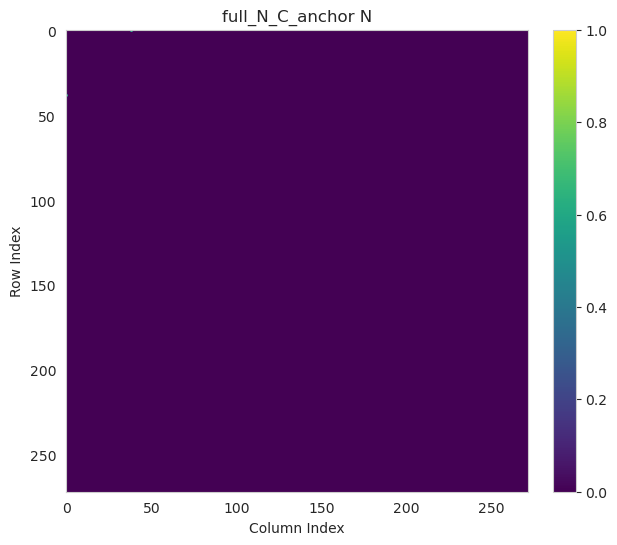

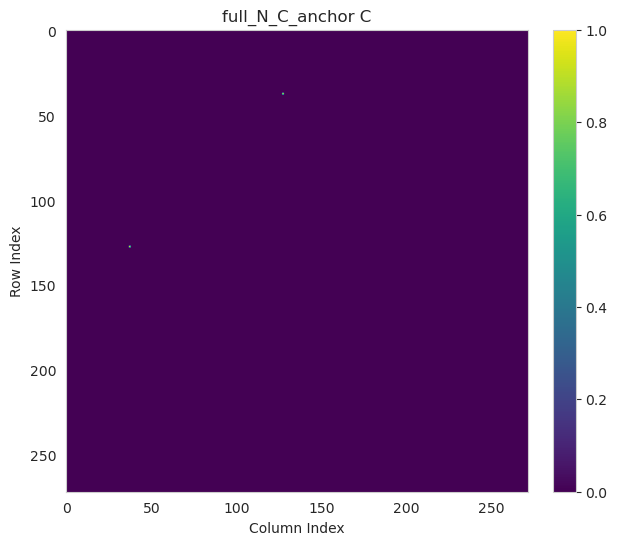

In [10]:
print(torch.where(batch_data['full_bond_matrix'][0] * (1-torch.eye(batch_data['full_bond_matrix'][0].shape[1],dtype=torch.float32,device=batch_data['full_bond_matrix'][0].device).unsqueeze(0))==1))
plot_tensor_heatmap(batch_data['full_bond_matrix'][0],"bond mat")
plot_tensor_heatmap(batch_data['full_bond_mask'][0], "bond mask")
plot_tensor_heatmap(batch_data['full_N_C_anchor'][0,:,:,0], "full_N_C_anchor N")
plot_tensor_heatmap(batch_data['full_N_C_anchor'][0,:,:,1], "full_N_C_anchor C")

In [11]:

# from rfdiff.util import writepdb
# import numpy as np
# from rfdiff.util_module import ComputeAllAtomCoords
# allatom = ComputeAllAtomCoords()
# print(batch_data['full_alpha'].shape)
# print(batch_data['full_xyz'].shape)
# _,atoms_to_save = allatom(batch_data['full_seq'],
#                         batch_data['full_xyz'][:,:,:3,:],
#                         batch_data['full_alpha'],use_H=False)

# # Get the first sample from the batch
# # seq_pred,xyz_pred[:,-1,...],alpha_s,use_H=False
# # atoms_to_save = allatom_xyz[0].cpu()
# seq_to_save = batch_data['full_seq'][0].cpu()
# res_mask_to_save = batch_data['res_mask'][0].cpu().numpy()
# atoms_to_save = atoms_to_save[0].cpu()


# # Filter atoms and sequence based on residue mask
# L = seq_to_save.shape[0]
# res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
# filtered_atoms = atoms_to_save[res_indices]
# filtered_seq = seq_to_save[res_indices]

# # Prepare arguments for writepdb
# outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output2.pdb"
# res = filtered_seq
# ch = ['A'] * len(filtered_seq) # Assuming a single chain 'A'
# resi = res_indices + 1 # PDB residue indices are 1-based

# # Write the PDB file
# writepdb(outfile, filtered_atoms, res)

# print(f"Saved PDB file to {outfile}")

In [12]:
torch.set_printoptions(profile='full')
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts
import torch.optim  as optim 
criterion_frame = LFrameLoss(w_trans=0.5, w_rot=1,gamma=1,d_clamp = 25)
criterion_seq = LseqLoss()
criterion_bond = DSMCrossEntropyLoss()
criterion_FAPE = FAPELoss(clamp_distance = 20)
criterion_clash = OpenFoldClashLoss(device=device,debug_print_pairs=True)
criterion_torsion = TorsionLossLegacy()
link_csv_path = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv"
criterion_bond_coh = BondCoherenceLoss(link_csv_path=link_csv_path, device=device,t_geom_threshold=0.5)
model = sampler.model
optimizer = optim.AdamW(model.parameters(), lr=1e-4,weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-5)
from torch.amp import autocast, GradScaler
use_amp = False
scaler = GradScaler("cuda",enabled=use_amp)


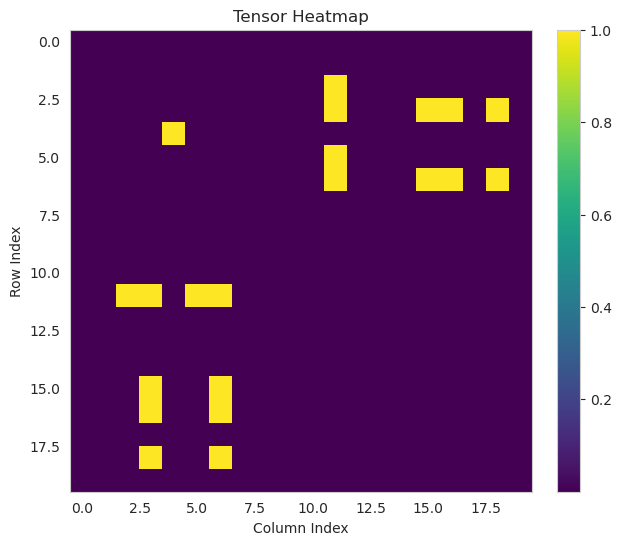

In [13]:
plot_tensor_heatmap(criterion_bond_coh.compat_matrix.cpu())

In [14]:
def calculate_norm(loss, params_to_check,name):
    if loss.item() == 0:
        print(f"{name} loss is zero, skipping gradient calculation.")
        return 0.0
    fape_grads = torch.autograd.grad(loss, params_to_check, retain_graph=True, allow_unused=True)
    total_norm = 0.0
    for grad in fape_grads:
        if grad is not None:
            # 确保梯度不是空的 (如果allow_unused=True)
            total_norm += grad.data.norm(2).item() ** 2
    print( f"{name} grad:", total_norm ** 0.5)
    return total_norm ** 0.5


with torch.autograd.detect_anomaly():
    # for i in range(1000):
    import time 
    total_time = 0



    for i, batch_data in enumerate(dataloader_train):
        print("start "*10)
        # if (i+1) // 64 != 115 or(i+1) // 64 != 116:
        #     continue
        #with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):

        print(batch_data['pdb_id'])
        start_time = time.time()
        loss_frame, loss_seq, loss_bond, loss_clash, loss_FAPE, loss_torsion, loss_bond_coh,partial_T,  seq_pred, res_mask = model_forward(
                                                        sampler,
                                                        batch_data,
                                                        criterion_frame,
                                                        criterion_seq,
                                                        criterion_bond,
                                                        criterion_FAPE,
                                                        criterion_torsion,
                                                        criterion_bond_coh,
                                                        criterion_clash=criterion_clash
                                                        )

        print("loss frame",loss_frame.item())
        print("loss seq",loss_seq.item())
        print("loss bond",loss_bond.item())
        print("loss clash",loss_clash.item())
        print("loss FAPE",loss_FAPE.item())
        print("loss torsion",loss_torsion.item())
        print("loss bond_coh",loss_bond_coh.item())
        print("partial_T",partial_T)
        pdb_id = batch_data['pdb_id']
        #loss_total = loss_frame + loss_seq + loss_bond + loss_clash + loss_FAPE + loss_torsion

            # 为了效率，我们只检查最后一个共享层的参数
        # params_to_check = list(model.parameters())
        
        # loss_dict = {'frame':loss_frame, 'seq':loss_seq, 'bond':loss_bond, 'clash':loss_clash, 'FAPE':loss_FAPE, 'torsion':loss_torsion}
        # if params_to_check: # 确保参数列表不为空
        #     for name, loss in loss_dict.items():
        #         print(f"{name} loss:", loss.item())
        #         fape_grad_norm = calculate_norm(loss, params_to_check,name)

        loss_total =  0.75*loss_frame+ loss_seq +  loss_bond + 0.2*loss_clash +   0.25*loss_FAPE  + 0.5* loss_torsion + loss_bond_coh
        loss_total.backward()

        # for name, p in sampler.model.named_parameters():
        #     if p.requires_grad and p.grad is None:
        #         print("No grad:", name)

        # is_grad_nan_or_inf = torch.tensor([False])
        # for param in sampler.model.parameters():
        #     if param.grad is not None and (torch.isinf(param.grad).any() or torch.isnan(param.grad).any()):
        #         is_grad_nan_or_inf[0] = True
        #         print(f"Gradient is NaN or Inf for parameter: {param} at step {i} at pdb_id {pdb_id}")
        #         break # 发现一个就足够了，直接跳出循环
        #scaler.scale(loss_total).backward()


        # nn.utils.clip_grad_norm_(sampler.model.parameters(), 1)

        # total_norm = 0
        # for name, p in model.named_parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)
        #         #if param_norm.item()>1:
        #         total_norm += param_norm.item() ** 2
        # total_norm = total_norm ** 0.5
        # print(f"Total gradient norm: {total_norm}")

        # max_norm = 5
        # torch.nn.utils.clip_grad_norm_(sampler.model.parameters(), max_norm=max_norm)
        # scaler.step(optimizer)
        # scaler.update()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        # if loss_bond.item() < 0.1:
        #     print("loss_bond is too small, break")
        #     print(i)
        #     break
        # if loss_bond_coh>10:
    

        print("all time:", time.time() - start_time)



/tmp/ipykernel_1846466/3735595581.py:15: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


chosen_pdb_id AF-O67766-F1-model_v4_A
[['A/1-A/32:seq_PNA:str_PNA', 'A/33-A/44:seq_FIX:str_FIX', 'A/45-A/79:seq_PNA:str_PNA', 'A/80-A/81:seq_FIX:str_FIX', 'A/82-A/126:seq_PNA:str_PNA', 'New_144-144']]
chosen_pdb_id 3ZVS_B
[['B/1-B/160:seq_PNA:str_PNA', 'New_110-110']]
chosen_pdb_id 1LN0_B
[['B/1-B/94:seq_PNA:str_PNA', 'New_176-176']]
chosen_pdb_id AF-P75584-F1-model_v4_A
[['A/105-A/374:seq_PNA:str_PNA']]
chosen_pdb_id AF-Q501D5-F1-model_v4_A
[['A/41-A/310:seq_PNA:str_PNA']]
chosen_pdb_id AF-Q2NWC8-F1-model_v4_A
[['A/1-A/58:seq_PNA:str_PNA', 'A/59-A/75:seq_FIX:str_FIX', 'A/76-A/125:seq_PNA:str_PNA', 'A/126-A/150:seq_FIX:str_FIX', 'A/151-A/200:seq_PNA:str_PNA', 'New_70-70']]
chosen_pdb_id AF-Q7W2T7-F1-model_v4_A
[['A/41-A/310:seq_PNA:str_PNA']]
chosen_pdb_id 6JSB_B
[['B/34-B/83:seq_PNA:str_PNA', 'B/84-B/105:seq_FIX:str_FIX', 'B/106-B/161:seq_PNA:str_PNA', 'B/162-B/182:seq_FIX:str_FIX', 'B/183-B/231:seq_PNA:str_PNA', 'New_72-72']]
start start start start start start start start start star

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.13 GiB. GPU 0 has a total capacity of 79.32 GiB of which 751.00 MiB is free. Including non-PyTorch memory, this process has 78.58 GiB memory in use. Of the allocated memory 76.73 GiB is allocated by PyTorch, and 1.32 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for i, batch in enumerate(dataloader_train):
    batch_data = batch
    break
#with torch.autograd.detect_anomaly():
loss_frame, loss_seq, loss_bond, loss_clash, loss_FAPE, loss_torsion, loss_bond_coh,partial_T,  seq_pred, res_mask = model_forward(sampler,batch_data,
                                                criterion_frame,
                                                criterion_seq,
                                                criterion_bond,
                                                criterion_FAPE,
                                                criterion_torsion,
                                                criterion_bond_coh,
                                                criterion_clash=criterion_clash
                                                )
print("loss frame",loss_frame)
print("loss seq",loss_seq)
print("loss bond",loss_bond)
print("loss clash",loss_clash)
print("loss FAPE",loss_FAPE)
print("loss torsion",loss_torsion)
print("loss bond_coh",loss_bond_coh)
print("partial_T",partial_T)
#loss_total = loss_frame + loss_seq + loss_bond + loss_clash + loss_FAPE + loss_torsion
loss_total =  loss_bond_coh #loss_frame+ loss_seq + loss_bond + loss_clash +  loss_torsion +loss_FAPE  + loss_bond_coh
loss_total.backward()


# 监控并打印梯度范数
total_norm = 0
for name, p in model.named_parameters():
    if p.grad is not None:
        param_norm = p.grad.data.norm(2)
        #if param_norm.item()>1:
        print(name,param_norm.item())
        total_norm += param_norm.item() ** 2
total_norm = total_norm ** 0.5
print(f"Total gradient norm: {total_norm}")

#更新梯度


optimizer.step()
optimizer.zero_grad()


chosen_pdb_id 9CDT_A
[['A/0-A/149:seq_PNA:str_PNA']]
GPU Memory after data to device: 5264.12 MB
partial_T tensor([0.5446], device='cuda:0')
motif_center tensor([[[ -9.3816,  12.9152, -11.7743]]], device='cuda:0')
yuandian tensor([[ 5.3958e-07, -3.0116e-07,  7.5917e-07]], device='cuda:0')
xyz_noised 0 tensor([[2.8891, 4.4715, 4.1250],
        [1.8172, 4.4024, 3.1392],
        [2.1230, 5.2778, 1.9306]], device='cuda:0')
xyz_noised 1 tensor([[ 7.0575, -5.5848,  8.6818],
        [ 7.3670, -4.1786,  8.4522],
        [ 6.7578, -3.6869,  7.1455]], device='cuda:0')
GPU Memory after after sample_with_interpolant: 5264.23 MB
GPU Memory after after _preprocess_batch: 5264.23 MB
model forward time: 0.1851491928100586
GPU Memory after after model forward pass: 8314.98 MB
R loss: 0.1838
T loss: 2.5671
frame loss time: 0.004258632659912109
GPU Memory after after loss_frame: 8315.04 MB
FAPE loss time: 0.0019555091857910156
GPU Memory after after loss_FAPE: 8316.55 MB
seq loss time: 0.0003118515014648